In [3]:
import torch
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from PIL import Image
import pandas as pd
from torchvision import transforms
from sklearn.model_selection import train_test_split
import preprocessing
import torch.optim as optim

In [4]:
def split_data(df):
    train_ratio = 0.7
    val_ratio = 0.2
    test_ratio = 0.1
    
    df_use, df_discard = train_test_split(df, test_size=0.8, random_state=42)

    train_val, test = train_test_split(df_use, test_size=test_ratio, random_state=42)
    train, val = train_test_split(train_val, test_size=val_ratio/(train_ratio + val_ratio), random_state=42)

    return train, val, test

In [5]:
class CustomDataset2(Dataset):
    def __init__(self, image_folder, dataframe, transform=None):
        self.image_folder = image_folder
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0] + '.jpg'  # Assuming the image column is 'Image_ID'
        age = torch.tensor(self.dataframe.iloc[idx,1])

        # Lazy loading: return the image path and label instead of loading the image
        return img_name, age

    def load_image(self, img_name):
        img_path = self.image_folder + '/' + img_name
        image = Image.open(img_path).convert('RGB')
        #need a transformer for test images just to convert to tensor and to resahape and allat
        if self.transform == 'train' or self.transform == 'val':
            # Define transformations for data augmentation
            transform = transforms.Compose([
                transforms.Resize((100, 100)),
                transforms.RandomHorizontalFlip(),
                # transforms.RandomRotation(20),
                transforms.ToTensor(),
                transforms.Grayscale(num_output_channels=1), 
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ])
            image = transform(image)
        elif self.transform == "test":
            transform = transforms.Compose([
                transforms.Resize((100, 100)),
                transforms.ToTensor(),
                transforms.Grayscale(num_output_channels=1), 
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ])
            image = transform(image)
        return image

In [6]:
data_path = '../data/UTKFace'
batch_size=32
df = pd.read_csv('../data/UTKFace_labels.csv', dtype={'Age':'float32', 'Gender':'float32'})
train_data, val_data, test_data = split_data(df) 

In [7]:
train_dataset = CustomDataset2(dataframe=train_data, image_folder=data_path, transform='train')
val_dataset = CustomDataset2(dataframe=val_data, image_folder=data_path, transform='val')
test_dataset = CustomDataset2(dataframe=test_data, image_folder=data_path, transform='test')

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# Iterate through the train_loader to get a batch of data
for batch_idx, (img_names, targets) in enumerate(train_loader):
    data = [train_dataset.load_image(img_name) for img_name in img_names]
    example_data = data  # This will contain a batch of images
    example_targets = targets  # This will contain the corresponding labels/targets
    break

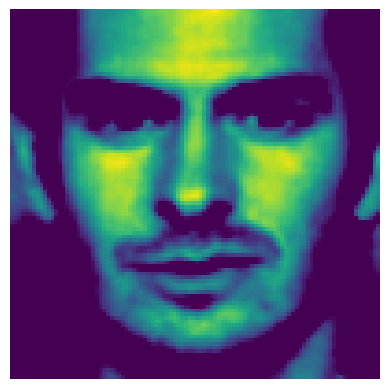

In [10]:
import matplotlib.pyplot as plt
import numpy as np  # If needed for conversion
import random

# Assuming image_tensor is your tensor data
# Convert tensor to NumPy array
image_array = example_data[random.randint(0,31)].numpy()  # PyTorch example; adjust accordingly for TensorFlow

# Reverse the normalization by scaling back to the original range [0, 255]
image_array = image_array * 255.0

# Clip values to ensure they are within the valid range [0, 255]
image_array = np.clip(image_array, 0, 255)

# Convert data type to unsigned 8-bit integer (uint8)
image_array = image_array.astype(np.uint8)

# If the tensor has color channels as the first dimension (e.g., [C, H, W])
# and you want to rearrange it to be [H, W, C] for display:
if len(image_array.shape) == 3:
    image_array = np.transpose(image_array, (1, 2, 0))  # Change the order of dimensions

# Display the image using Matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hide axis
plt.show()

In [11]:
tf.print(example_data)

[tensor([[[-0.7195, -0.7186, -0.7578,  ..., -0.8727, -0.8727, -0.8806],
         [-0.7140, -0.7343, -0.7735,  ..., -0.8727, -0.8806, -0.8806],
         [-0.7108, -0.7601, -0.8002,  ..., -0.8727, -0.8806, -0.8727],
         ...,
         [ 0.2472,  0.2472,  0.2472,  ..., -0.5280, -0.6770, -0.8495],
         [ 0.2472,  0.2472,  0.2472,  ..., -0.5045, -0.6378, -0.8025],
         [ 0.2472,  0.2472,  0.2472,  ..., -0.4810, -0.5751, -0.7162]]]),
 tensor([[[-0.7715, -0.7559, -0.7480,  ..., -0.8723, -0.8879, -0.9036],
         [-0.7166, -0.7323, -0.7480,  ..., -0.8644, -0.8801, -0.8879],
         [-0.7166, -0.7480, -0.7402,  ..., -0.8644, -0.8723, -0.8801],
         ...,
         [-0.6552, -0.6709, -0.6558,  ...,  0.1408, -0.1085,  0.0114],
         [-0.6395, -0.6700, -0.6401,  ...,  0.2386, -0.0250,  0.1132],
         [-0.6160, -0.6631, -0.6323,  ...,  0.3161, -0.0032,  0.0042]]]),
 tensor([[[-0.4757, -0.4165, -0.4449,  ...,  0.7798,  0.7641,  0.7484],
         [-0.4821, -0.3993, -0.3290,  ..

In [12]:
tf.print(example_targets)

tensor([ 4., 15., 45.,  4., 17., 30.,  2., 20.,  1., 32.,  1., 30., 36., 24.,
        30.,  8., 32.,  9., 17., 10., 58.,  1., 60., 54., 36., 26.,  8.,  1.,
        22., 26., 25., 18.])


In [13]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        #self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dense_shared = nn.Linear(50 * 50 * 64, 128)  # Calculate the input size based on your input_shape

        # Output layers
        self.regression_output = nn.Linear(128, 1)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Identity()  # No activation for linear output

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.max_pool(x)

        # Flatten and pass through fully connected layers
        x = self.flatten(x)
        x = self.relu(self.dense_shared(x))

        # Classification branch
        regression_out = self.linear(self.regression_output(x)).squeeze()
        
        return regression_out

In [14]:
model = CustomModel()
loss_func = nn.MSELoss()

In [15]:
# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate as needed

train_losses = []
val_losses = []
# Training loop
epochs = 10  # Define the number of epochs for training

for epoch in range(epochs):
    print("epoch:", epoch)
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for batch_idx, (img_names, targets) in enumerate(train_loader):
        print(batch_idx)
        data = torch.stack([train_dataset.load_image(img_name) for img_name in img_names])
        # print(type(data))
        optimizer.zero_grad()  # Zero the gradients to prevent accumulation
        pred = model(data)  # Forward pass
         
        loss = loss_func(pred, targets)
        total_loss += loss.item()
        # Backpropagation
        loss.backward()
        optimizer.step()

    # Calculate average loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_train_loss:.4f}")
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0.0
        for batch_idx, (img_names, targets) in enumerate(val_loader):
            data = torch.stack([train_dataset.load_image(img_name) for img_name in img_names])
            pred = model(data)
            loss = loss_func(pred, targets)
            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch + 1}/{epochs}] - Validation Loss: {avg_val_loss:.4f}")

epoch: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
Epoch [1/10], Loss: 372.5405
Epoch [1/10] - Validation Loss: 260.9397
epoch: 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
Epoch [2/10], Loss: 235.0013
Epoch [2/10] - Validation Loss: 225.2387
epoch: 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


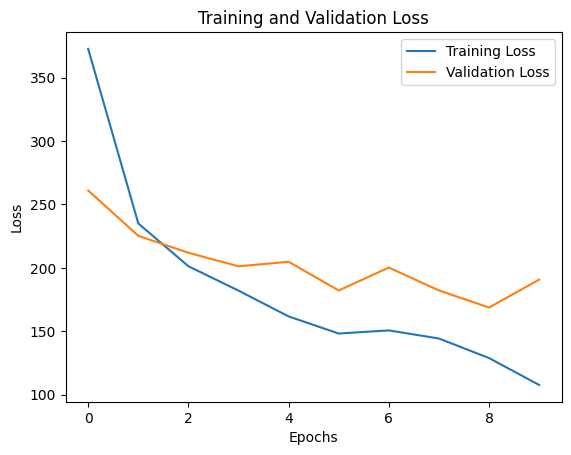

In [16]:
# Plotting losses over epochs
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
import torch
import torch.nn.functional as F

# Set the model to evaluation mode
model.eval()

# Initialize variables for MSE calculation
total_mse_model = 0.0
total_mse_baseline = 0.0
total_samples = 0

# Calculate the mean value in the training set (to use as the baseline prediction)
train_targets = []  # Collect training targets
for _, targets in train_loader:
    train_targets.extend(targets.numpy())

baseline_prediction = torch.tensor(train_targets).float().mean().item()

# Iterate through the test dataset
with torch.no_grad():
    for batch_idx, (img_names, targets) in enumerate(test_loader):
        data = torch.stack([test_dataset.load_image(img_name) for img_name in img_names])
        predictions = model(data)  # Get model predictions        

        # Calculate MSE for model predictions
        mse_model = F.mse_loss(predictions, targets, reduction='sum').item()
        total_mse_model += mse_model

        # Calculate MSE for baseline predictions (always predicting the mean)
        mse_baseline = F.mse_loss(torch.full_like(targets, baseline_prediction), targets, reduction='sum').item()
        total_mse_baseline += mse_baseline

        total_samples += len(targets)

# Calculate average MSE for both model and baseline
avg_mse_model = total_mse_model / total_samples
avg_mse_baseline = total_mse_baseline / total_samples

# Print MSE values
print(f"Model MSE: {avg_mse_model:.4f}")
print(f"Baseline (Predicting Mean) MSE: {avg_mse_baseline:.4f}")

# Calculate and print the improvement in MSE over the baseline
mse_improvement = avg_mse_baseline - avg_mse_model
print(f"Improvement over baseline MSE: {mse_improvement:.4f}")

Model MSE: 156.0526
Baseline (Predicting Mean) MSE: 378.2736
Improvement over baseline MSE: 222.2210


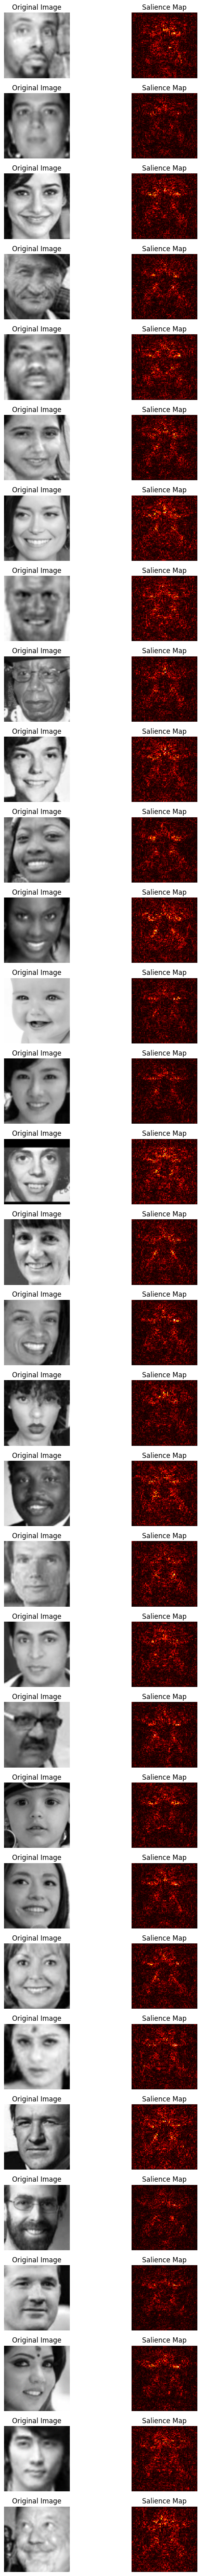

In [18]:
# Get the first batch from the test loader
batch_idx, (img_names, targets) = next(enumerate(test_loader))
data = torch.stack([test_dataset.load_image(img_name) for img_name in img_names])

# Get the gradients of the output with respect to the input
data.requires_grad = True
output = model(data)
loss = torch.nn.functional.cross_entropy(output, targets) 
loss.backward()

# Calculate the salience map from the gradients
salience_map = data.grad.abs().max(dim=1)[0].squeeze().detach().cpu().numpy()

# Plot the original image and salience map for each image in the batch
num_images = data.shape[0]
fig, axes = plt.subplots(num_images, 2, figsize=(8, 2 * num_images))  # Adjust the figure size as needed

for i in range(num_images):
    # Plot the original image
    original_image = data[i].squeeze().detach().cpu().numpy()
    axes[i, 0].imshow(original_image, cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Plot the salience map
    axes[i, 1].imshow(salience_map[i], cmap='hot', interpolation='nearest')
    axes[i, 1].set_title('Salience Map')
    axes[i, 1].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()